In [27]:
%load_ext autoreload
%autoreload 2
from easing import easing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Tabel of contents
* [Polyline animation](#polyline_animation2d)
* [Polygon animation](#polygon_animation2d)
* [Multi-component animation](#animation2d)


#### Load Data

For the following examples, we will animate the transition between two different datasets. 

**Context:** The datasets consist on 2D plot of angular velocity magnitudes versus time, for the relative motion between two tectonic plates, Nazca relative to the South American plate. The first dataset is obtained from Somoza & Ghidella (2012) [10.1016/j.epsl.2012.03.003] and the second from Quiero et al. (2022) [10.1038/s41467-022-29055-4]. The originally published data has been processed using the 'PlateKinematics' package from Julia [https://github.com/ValeEspinozaF/PlateKinematics.jl] in order to obtain the mean and standard deviation (upper and lower limits) of the motion vector.

In [28]:
# Somoza2012
som12_df = pd.read_csv("assets/angularmag_somoza2012.txt", names=["time", "mean", "tol1", "tol2"])

# Quiero2022
qui22_df = pd.read_csv("assets/angularmag_quiero2022.txt", names=["time", "mean", "tol1", "tol2"])

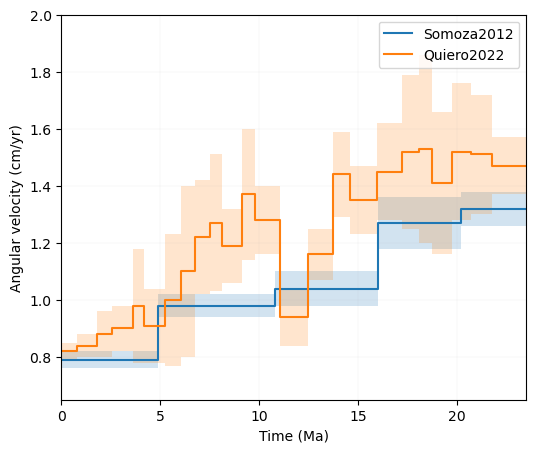

In [29]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.set(xlabel='Time (Ma)', ylabel='Angular velocity (cm/yr)')
ax.grid('grey', lw=0.3, alpha=0.2)
ax.set(xlim=(0, 23.5), ylim=(0.65, 2.0))

ax.plot(som12_df['time'], som12_df['mean'], label='Somoza2012')
ax.plot(qui22_df['time'], qui22_df['mean'], label='Quiero2022')

ax.fill_between(som12_df['time'], som12_df['tol1'], som12_df['tol2'], alpha=0.2)
ax.fill_between(qui22_df['time'], qui22_df['tol1'], qui22_df['tol2'], alpha=0.2)
ax.legend()

#### Static interpolation on the x-axis

Since the Quiero et al. (2022) dataset has a higher resolution than the Somoza & Ghidella (2012) dataset, we will interpolate the latter to match the resolution of the former. In the process, we will also add datapoints for all time points in both datasets, so that the transition is smooth.

In [30]:
new_data = pd.DataFrame({"time": qui22_df["time"]})
new_data = new_data[new_data["time"] > 0.0]

new_data['index'] = range(len(som12_df), len(som12_df) + len(new_data))

# Merge the new DataFrame with "som12"
som12_combined = pd.concat([som12_df, new_data], ignore_index=True)

# Sort the DataFrame by "time" and then by index
som12_combined.sort_values(by=["time", "index"], inplace=True)

# Reset the index to have a sorted DataFrame
som12_combined.reset_index(drop=True, inplace=True)

# Interpolate the missing values for "mean," "tol1," and "tol2" columns
som12_combined.interpolate(method="linear", limit_direction="both", inplace=True)

In [31]:
unique_times = som12_combined['time'].unique()
new_times_df = pd.DataFrame({'time': unique_times})

# Merge "qui22_df" with the new DataFrame based on "time"
qui22_combined = pd.merge(new_times_df, qui22_df, on="time", how="left")

# Add an "index" column to "qui22_combined"
qui22_combined['index'] = range(len(qui22_combined))

# Find unique time values that do not exist in "qui22"
missing_time_values = set(unique_times) - set(qui22_df['time'])

# Duplicate rows for missing time values
missing_rows = qui22_combined[qui22_combined['time'].isin(missing_time_values)]
qui22_combined = pd.concat([qui22_combined, missing_rows], ignore_index=True)

# Sort the resulting DataFrame by "time" and index
qui22_combined.sort_values(by="time", inplace=True)
qui22_combined.sort_values(by="index", inplace=True)

# Reset the index to have a sorted DataFrame
qui22_combined.reset_index(drop=True, inplace=True)

# Interpolate the missing values for "mean," "tol1," and "tol2" columns
qui22_combined.interpolate(method="linear", limit_direction="both", inplace=True)

#### Check interpolations

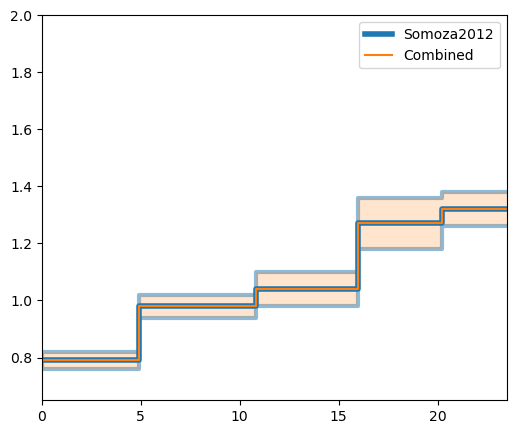

In [32]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.set(xlim=(0, 23.5), ylim=(0.65, 2.0))

ax.plot(som12_df['time'], som12_df['mean'], lw=4, label='Somoza2012')
ax.plot(som12_combined['time'], som12_combined['mean'], label='Combined')

ax.fill_between(som12_df['time'], som12_df['tol1'], som12_df['tol2'], alpha=0.5, fc='none', lw=3, ec='#1f77b4')
ax.fill_between(som12_combined['time'], som12_combined['tol1'], som12_combined['tol2'], alpha=0.2, fc='#ff7f0e')

ax.legend()

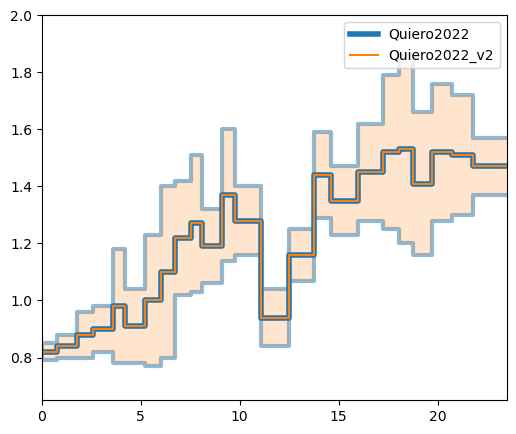

In [33]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.set(xlim=(0, 23.5), ylim=(0.65, 2.0))

ax.plot(qui22_df['time'], qui22_df['mean'], lw=4, label='Quiero2022')
ax.plot(qui22_combined['time'], qui22_combined['mean'], label='Quiero2022_v2')

ax.fill_between(qui22_df['time'], qui22_df['tol1'], qui22_df['tol2'], alpha=0.5, fc='none', lw=3, ec='#1f77b4')
ax.fill_between(qui22_combined['time'], qui22_combined['tol1'], qui22_combined['tol2'], alpha=0.2, fc='#ff7f0e')

ax.legend()

# Animate

## Animate mean - *polyline_animation2d* <a class="anchor" id="polyline_animation2d"></a>

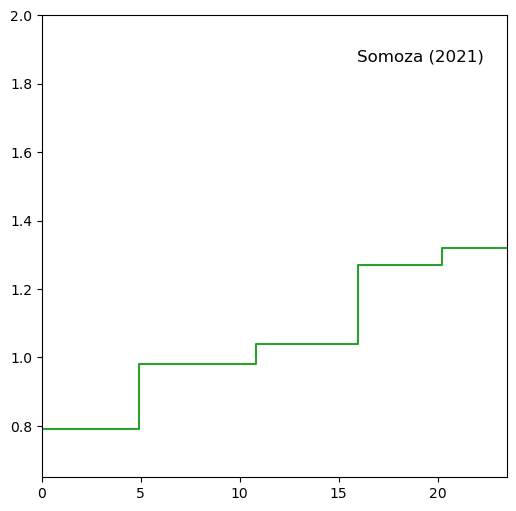

In [34]:
me1 = som12_combined[["time", "mean"]].to_numpy().reshape(1,-1)
me2 = qui22_combined[["time", "mean"]].to_numpy().reshape(1,-1)

data = pd.DataFrame(data = np.vstack([me1, me2]),
                    index = ['Somoza (2021)', 'Quiero et al. (2022)']
                    )

eased_line = easing.Eased(data, in_t=[0,1], wrap=False).power_ease(n=3, fpt=10, istall=False, fstall=False)

eased_line.polyline_animation2d(duration=0.4, label=True, 
                                feat_kws={'color':"#2ca02c"}, 
                                ax_kws=dict(xlim=(0, 23.5), ylim=(0.65, 2.0))
                                )

## Animate uncertainties - *polygon_animation2d* <a class="anchor" id="polygon_animation2d"></a>

In [35]:
def rect_uncertainties(line_x, line_yu, line_yl):
    
    n_y = len(line_yu)

    data_rect = np.zeros((n_y*2, 2))
    for i in range(len(line_yu)):
        data_rect[i] = [line_x[i], line_yu[i]]  
        data_rect[n_y*2 - 1 -(i)] = [line_x[i], line_yl[i]]

    return data_rect.reshape(1,-1)
   
un1 = rect_uncertainties(som12_combined["time"], som12_combined["tol1"], som12_combined["tol2"])
un2 = rect_uncertainties(qui22_combined["time"], qui22_combined["tol1"], qui22_combined["tol2"])

In [36]:
data = pd.DataFrame(data = np.vstack([un1, un2]),
                    index = ['Somoza (2021)', 'Quiero et al. (2022)'])

data

,0,1,2,3,4,5,6,7,8,9,...,238,239,240,241,242,243,244,245,246,247
Somoza (2021),0.0,0.76,0.781,0.76,0.781,0.76,1.778,0.76,1.778,0.76,...,1.778,0.82,1.778,0.82,0.781,0.82,0.781,0.82,0.0,0.82
Quiero et al. (2022),0.0,0.79,0.781,0.79,0.781,0.80,1.778,0.80,1.778,0.80,...,1.778,0.96,1.778,0.88,0.781,0.88,0.781,0.85,0.0,0.85


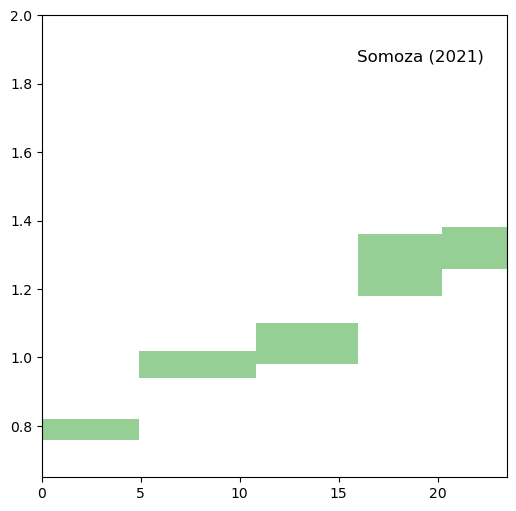

In [37]:
data = pd.DataFrame(data = np.vstack([un1, un2]),
                    index = ['Somoza (2021)', 'Quiero et al. (2022)']
                    )

eased_rect = easing.Eased(data, wrap=False).no_ease(fpt=17)

eased_rect.polygon_animation2d(duration=0.4, label=True, 
                               feat_kws={'alpha':0.5, 'fc':'#2ca02c'}, 
                               ax_kws=dict(xlim=(0, 23.5), ylim=(0.65, 2.0)), 
                               #destination='media/multipoint.gif',
                               )

## Animate multiple components - *animation2d* <a class="anchor" id="animation2d"></a>

MovieWriter imagemagick unavailable; using Pillow instead.


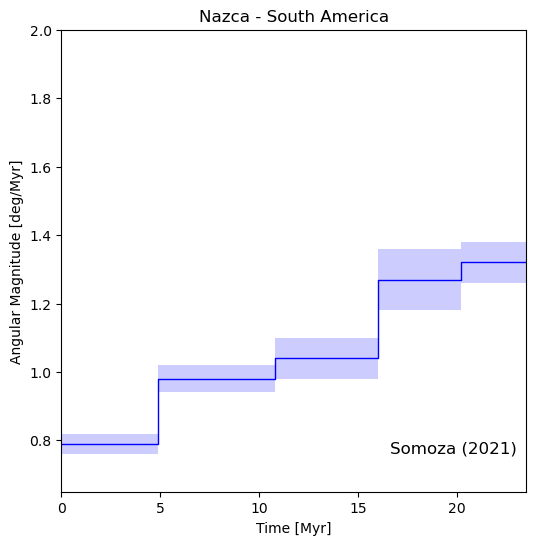

In [38]:
data_un = pd.DataFrame(np.vstack([un1, un2]), index = ['Somoza (2021)', 'Quiero et al. (2022)'])
data_me = pd.DataFrame(np.vstack([me1, me2]), index = ['Somoza (2021)', 'Quiero et al. (2022)'])

eased_rect = easing.Eased(data_un, in_t=[0,1,1,1], wrap=True).power_ease(n=3, fpt=20, istall=True, fstall=True)
eased_line = easing.Eased(data_me, in_t=[0,1,1,1], wrap=True).power_ease(n=3, fpt=20, istall=True, fstall=True)

eased_list = [eased_rect, eased_line]
anim_type = ['polygon', 'line']

easing.animation2d(eased_list, anim_type, 
                   duration=1, save_main_frames=False, 
                   feats_kws=[dict(facecolor='blue',
                                   alpha=0.2), 
                              dict(color='blue')],
                   ax_kws=dict(xlim=(0, 23.5), 
                               ylim=(0.65, 2.0),
                               ylabel='Angular Magnitude [deg/Myr]',
                               xlabel='Time [Myr]',
                               title = "Nazca - South America"
                               ), 
                   label=True, label_kws=dict(position = (23.0, 0.8)),
                   destination=r"angularmag.gif"
                   )